In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import shap

In [3]:
#Leemos el CSV
df=pd.read_csv("data_tfe.csv")
#Realizamos one-hot encoding sobre la variable city_grouped
df=pd.get_dummies(df,columns=['city_grouped'])
#Convertimos los bool en int 
df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)
#Transformamos la variable main_sector en una variable binaria  que tomará 1 en el caso de que el sector sea tech y cero non-tech
df['main_sector']=df['main_sector'].apply(lambda x: 1  if x=='tech' else 0  )

# Generamos el DF de características y el de la variable objetivo 
X = df.drop(columns='labels')
Y = df['labels']
# Train split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [9]:
#Modelo MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(X_train.shape[1],))
x = Dense(32, activation='relu')(input_layer)
x = Dense(16, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3784 - loss: 0.9975 - val_accuracy: 0.6212 - val_loss: 0.5246
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7281 - loss: 0.4072 - val_accuracy: 0.7879 - val_loss: 0.3455
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8427 - loss: 0.3094 - val_accuracy: 0.8939 - val_loss: 0.2279
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9298 - loss: 0.1982 - val_accuracy: 0.9848 - val_loss: 0.1447
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9773 - loss: 0.1275 - val_accuracy: 0.9848 - val_loss: 0.0960
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0979 - val_accuracy: 0.9848 - val_loss: 0.0729
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9747 - loss: 0.0982 - val_accuracy: 0.9848 - val_loss: 0.0597
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.0782 - val_accuracy: 0.9848 - val_loss:

In [5]:
#CLASSIFICATION REPORT DEL CONJUNTO TEST DEL MODELO 
from sklearn.metrics import classification_report
#Calculamos la predicciones para los datos test
y_pred= model.predict(X_test) 
#Transformamos la salida probabilistica de nuestra red en una variable binaria 
y_pred = pd.Series(y_pred.flatten()).apply(lambda x: 1 if x >= 0.5 else 0)
#Devolvemos el clasification report
print(classification_report(y_test, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        55
           1       1.00      0.98      0.99       110

    accuracy                           0.99       165
   macro avg       0.98      0.99      0.99       165
weighted avg       0.99      0.99      0.99       165



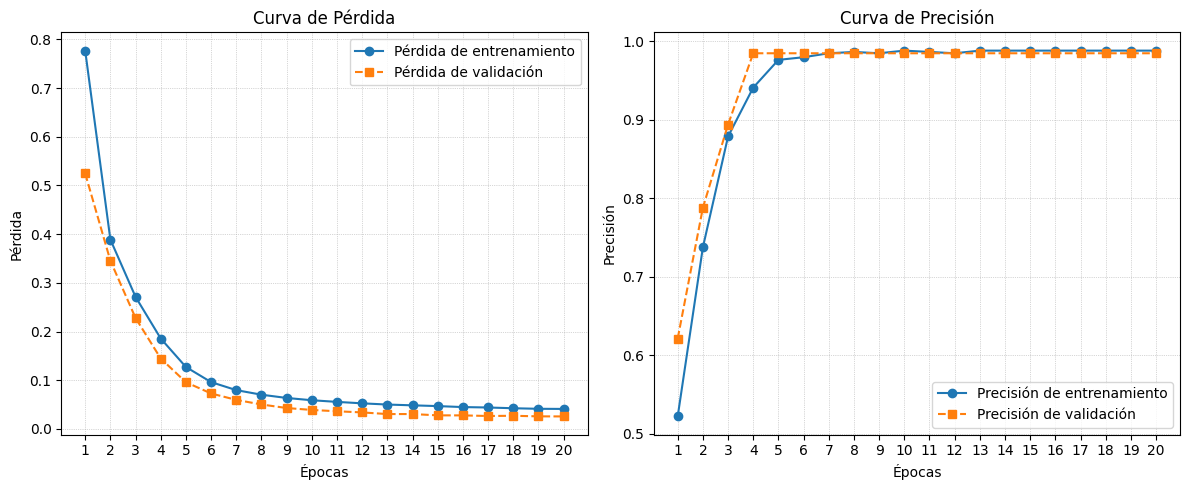

In [10]:
#Gráficos de perdida y presición 

#En la variable metricas guardamos el diccionario que tiene estos parametros almacenados
metricas=model.history.history

#Definimos el numero de epochs como la longuitud de las metricas 
epochs = np.arange(1, len(metricas['loss']) + 1)

#Tamaño  del gráfico
plt.figure(figsize=(12, 5))

# Curva de pérdida
plt.subplot(1, 2, 1)
#Perdida conjunto de  datos train
plt.plot(epochs, metricas['loss'], marker='o', linestyle='-', label='Pérdida de entrenamiento')
#Perdida conjunto de datos validacion (10% de los datos train)
plt.plot(epochs, metricas['val_loss'],marker='s', linestyle='--', label='Pérdida de validación')
#Títulos y etiquetas
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.xticks(epochs)                     
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend()

# Curva de precisión
plt.subplot(1, 2, 2)
#Precisión del conjunto de datos train 
plt.plot(epochs, metricas['accuracy'],marker='o', linestyle='-',label='Precisión de entrenamiento')
#Precisión del conjunto de datos validacion (10% de los datos train)
plt.plot(epochs, metricas['val_accuracy'],marker='s', linestyle='--', label='Precisión de validación')
#Títulos y etiquetas
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.xticks(epochs)                       
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


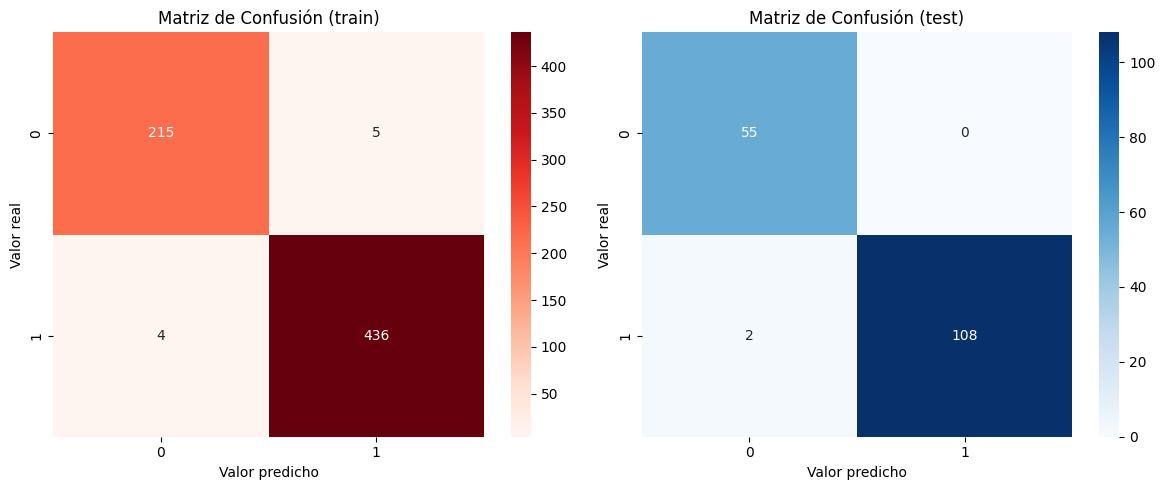

In [11]:
#Matriz de confunsión 

#Conjunto train 
y_pred_t=model.predict(X_train)
y_pred_t=pd.Series(y_pred_t.flatten()).apply(lambda x: 1 if x >= 0.5 else 0)
labels=[0,1]
#Matriz de confusión
cm_train=confusion_matrix(y_train,y_pred_t)
#Headmap 
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión (train)")

#Conjunto test
#Matriz de confusión
cm_test=confusion_matrix(y_test,y_pred)
#headmap
plt.subplot(1,2,2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión (test)")

plt.tight_layout()
plt.show()

### Calculo de los valores SHAP
He tratado de eliminar los warnings, que al parecer son por temas de estructura, pero no consigo eliminarlos. Queda pendiente ver la forma de eliminarlos o aclarar si tienen o no impacto en la salida que parece que no lo tienen.

c:\Users\rauls\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_4
Received: inputs=['Tensor(shape=(165, 22))']
  warnings.warn(msg)
c:\Users\rauls\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_4
Received: inputs=['Tensor(shape=(50, 22))']
  warnings.warn(msg)
C:\Users\rauls\AppData\Local\Temp\ipykernel_50856\1514387955.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(np.squeeze(shap_values), X_to_explain,feature_names=X_test.columns)


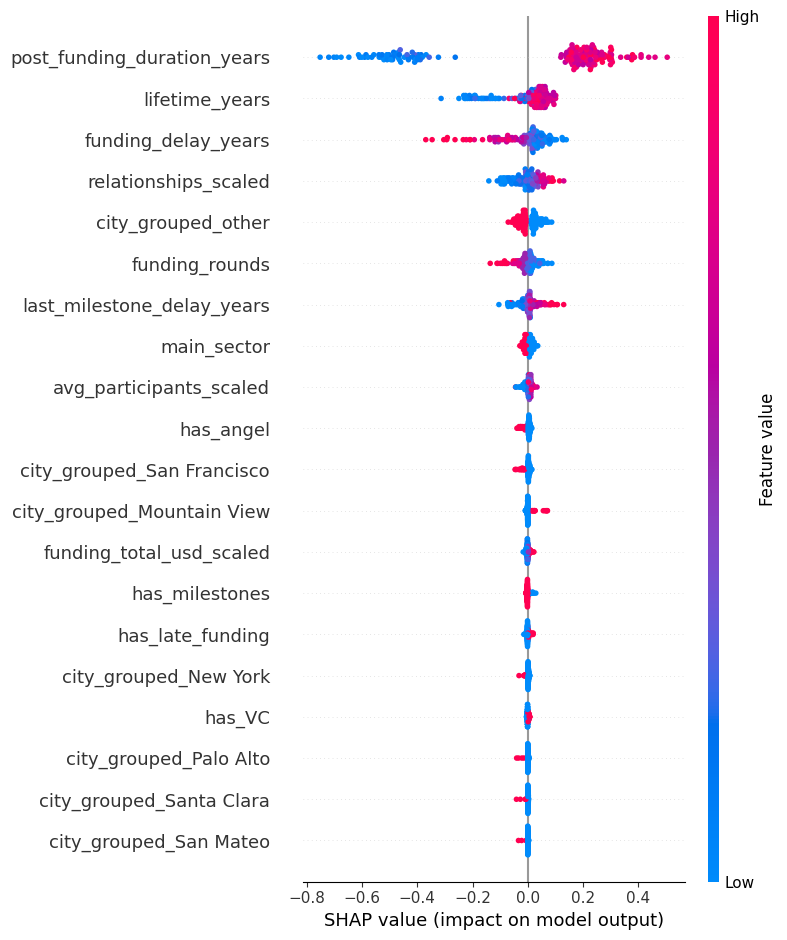

In [12]:
#CALCULO DE LOS VALORES SHAP 
import shap 
import tensorflow as tf
#Transformamos los dataset en numpy arrays 
X_background = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_to_explain = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

#Ejecutamos el metodo DeepExplainer pasandole el modelo y los datos train
explainer = shap.GradientExplainer(model, X_background)

#Calculamos los valores shap para el conjunto test
shap_values = explainer.shap_values(X_to_explain )
#Obtenemos el summary plot 
shap.summary_plot(np.squeeze(shap_values), X_to_explain,feature_names=X_test.columns)


#shap.summary_plot(np.squeeze(shap_values), X_to_explain_df, plot_type='bar', cmap='viridis')

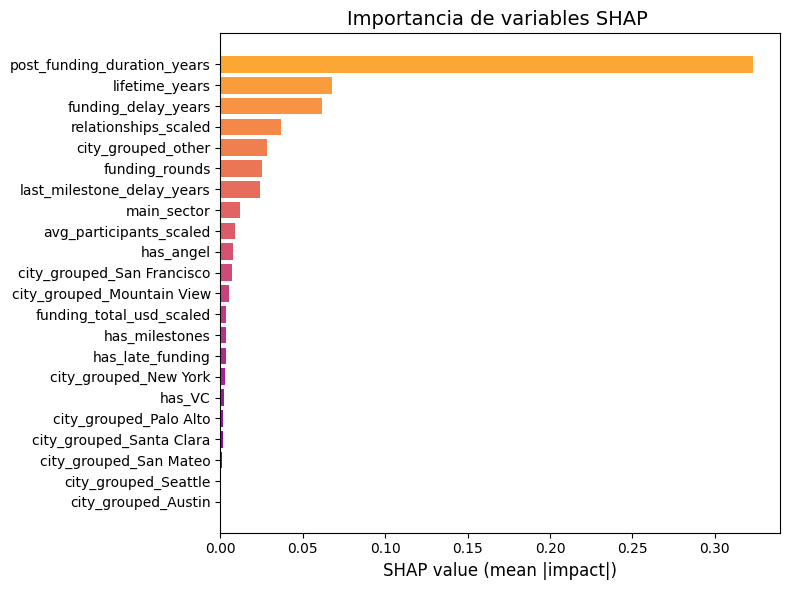

In [13]:
# Calcular importancia media absoluta por feature
shap_importance = np.abs(np.squeeze(shap_values)).mean(axis=0)
feature_names = X_test.columns
#Definimos un DF con las medias de los valores shap para cada variable para facilitar la modificacion de los gráficos
shap_df = pd.DataFrame({
    'feature': feature_names,
    'importance': shap_importance
}).sort_values(by='importance', ascending=True)

# Graficar
plt.figure(figsize=(8, 6))
plt.barh(shap_df['feature'], shap_df['importance'], color=plt.cm.plasma(np.linspace(0.2, 0.8, len(shap_df))))
plt.xlabel("SHAP value (mean |impact|)", fontsize=12)
plt.title("Importancia de variables SHAP ", fontsize=14)
plt.tight_layout()
plt.show()

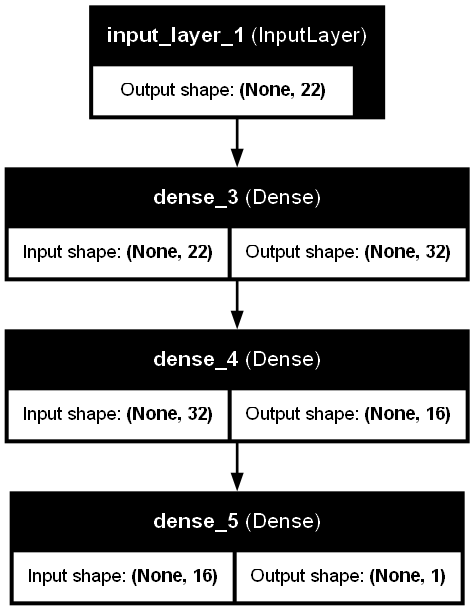

In [14]:
from tensorflow.keras.utils import plot_model  # o from keras.utils.vis_utils import plot_model

# 'model' es tu instancia de tf.keras.Model o keras.Model
plot_model(
    model,
    to_file="model_plot.png",    # Nombre del archivo de salida
    show_shapes=True,            # Muestra los tamaños de tensor en cada capa
    show_dtype=False,            # Muestra los tipos de dato de tensor
    show_layer_names=True,       # Muestra el nombre de cada capa
    rankdir="TB",                # 'TB' (top→bottom) o 'LR' (left→right)
    expand_nested=False,         # Despliega submodelos anidados
    dpi=96                       # Resolución de la imagen
)